## Импорт библиотек

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import warnings

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from bayes_opt import BayesianOptimization


## Загрузка данных

In [5]:
df  = pd.read_excel('fetch_california_housing.xlsx')
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41,6.984127,1.023810,322,2.555556,37.88,-122.23,4.526
1,8.3014,21,6.238137,0.971880,2401,2.109842,37.86,-122.22,3.585
2,7.2574,52,8.288136,1.073446,496,2.802260,37.85,-122.24,3.521
3,5.6431,52,5.817352,1.073059,558,2.547945,37.85,-122.25,3.413
4,3.8462,52,6.281853,1.081081,565,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25,5.045455,1.133333,845,2.560606,39.48,-121.09,0.781
20636,2.5568,18,6.114035,1.315789,356,3.122807,39.49,-121.21,0.771
20637,1.7000,17,5.205543,1.120092,1007,2.325635,39.43,-121.22,0.923
20638,1.8672,18,5.329513,1.171920,741,2.123209,39.43,-121.32,0.847


In [6]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())


Размер датасета: (20640, 9)
Пропущенные значения:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64


## EDA

In [7]:
df.describe().T.style.background_gradient(cmap='YlOrRd')


,count,mean,std,min,25%,50%,75%,max
MedInc,20640.000000,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.000000,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.000000,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.000000,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.000000,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.000000,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.000000,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.000000,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
target,20640.000000,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


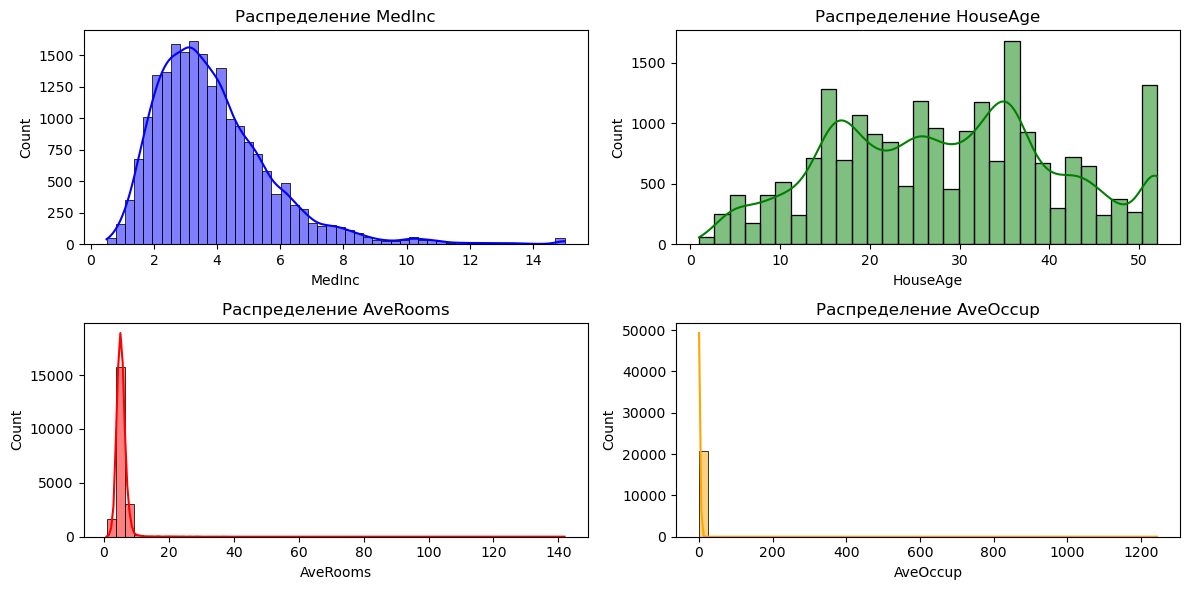

In [8]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['MedInc'], bins=50, kde=True, color='blue')
plt.title('Распределение MedInc')

plt.subplot(2, 2, 2)
sns.histplot(df['HouseAge'], bins=30, kde=True, color='green')
plt.title('Распределение HouseAge')

plt.subplot(2, 2, 3)
sns.histplot(df['AveRooms'], bins=50, kde=True, color='red')
plt.title('Распределение AveRooms')

plt.subplot(2, 2, 4)
sns.histplot(df['AveOccup'], bins=50, kde=True, color='orange')
plt.title('Распределение AveOccup')

plt.tight_layout()
plt.show()



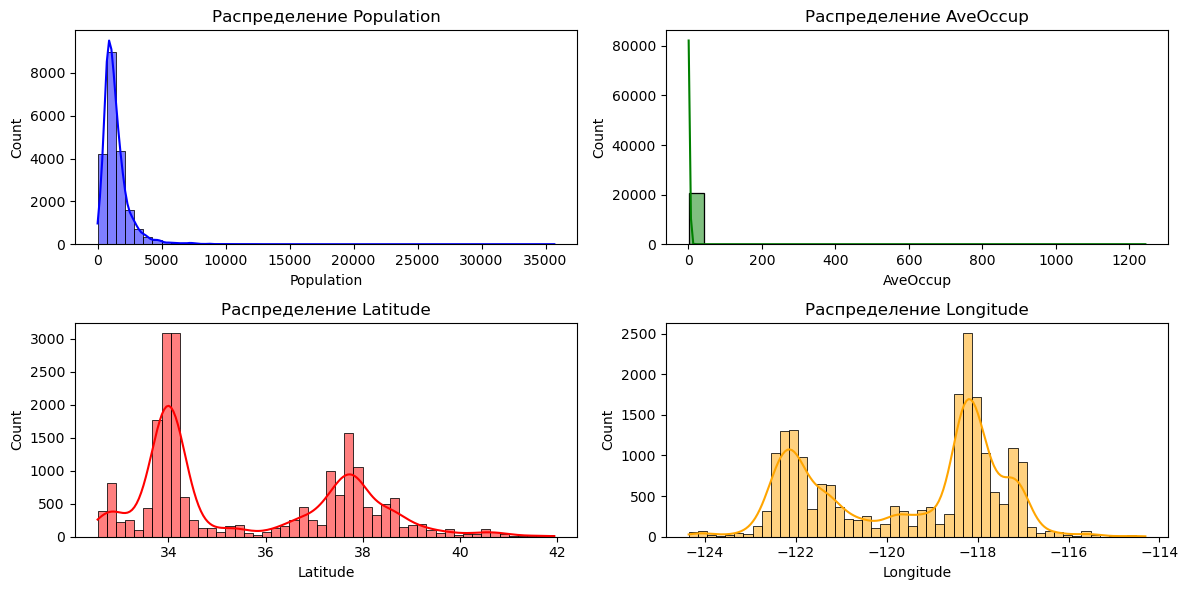

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['Population'], bins=50, kde=True, color='blue')
plt.title('Распределение Population')

plt.subplot(2, 2, 2)
sns.histplot(df['AveOccup'], bins=30, kde=True, color='green')
plt.title('Распределение AveOccup')

plt.subplot(2, 2, 3)
sns.histplot(df['Latitude'], bins=50, kde=True, color='red')
plt.title('Распределение Latitude')

plt.subplot(2, 2, 4)
sns.histplot(df['Longitude'], bins=50, kde=True, color='orange')
plt.title('Распределение Longitude')

plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Распределение target')

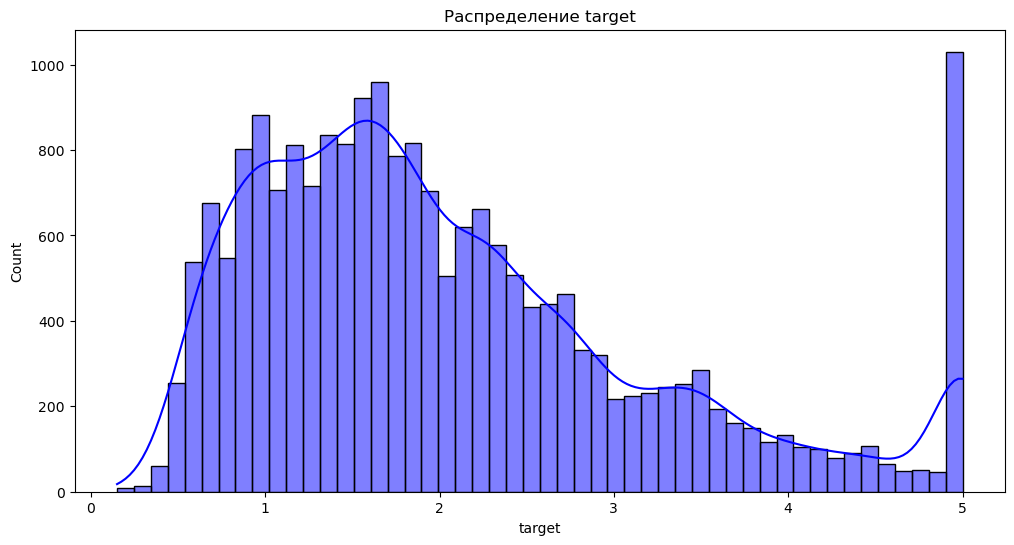

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df['target'], bins=50, kde=True, color='blue')
plt.title('Распределение target')


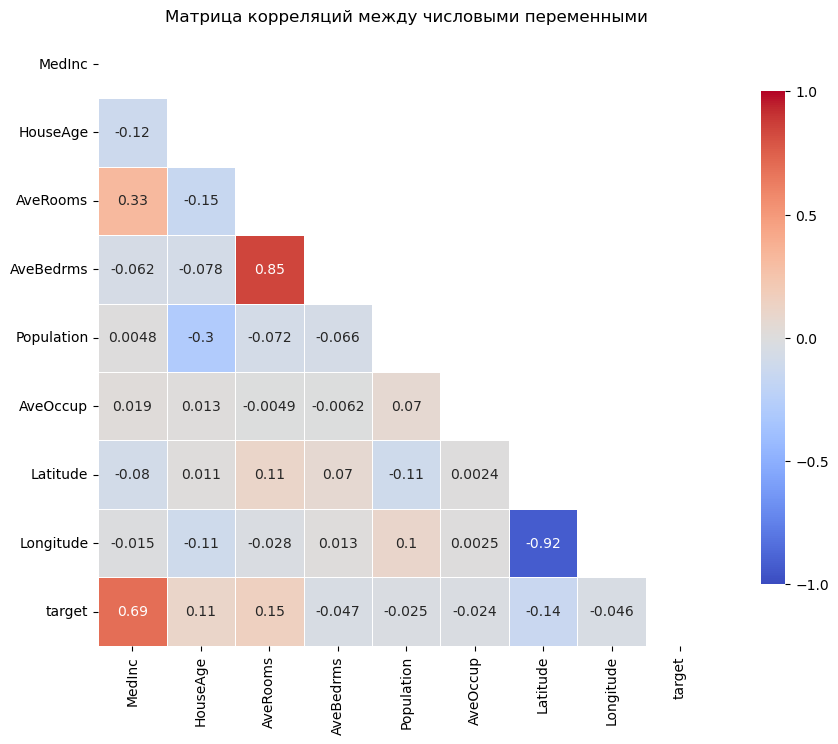

In [14]:
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0, 
            square=True, linewidths=.5, annot_kws={"size": 10}, 
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
plt.title('Матрица корреляций между числовыми переменными')
plt.show()


## Подготовка данных к обучению

In [16]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер X_train: {len(X_train)}")
print(f"Размер X_test: {len(X_test)}")
print(f"Размер y_train: {len(y_train)}")
print(f"Размер y_test: {len(y_test)}")


Размер X_train: 16512
Размер X_test: 4128
Размер y_train: 16512
Размер y_test: 4128


## Поиск лучшей модели RandomForestRegressor 

In [27]:
# Функция для кросс-валидации при обучении модели
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    n_estimators = int(n_estimators)
    max_depth = None if int(max_depth) == 0 else int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    max_features = float(max_features)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Кросс-валидация
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    # Возвращаем среднее значение RMSE
    return scores.mean()

# Определение пространства параметров для байесовской оптимизации
param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (0, 30),  # 0 означает None
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'max_features': (0.1, 1.0)  # Пропорция от числа признаков
}

optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=10, n_iter=30)
best_params_rf = optimizer.max['params']
best_params_rf['n_estimators'] = int(best_params_rf['n_estimators'])
best_params_rf['max_depth'] = None if int(best_params_rf['max_depth']) == 0 else int(best_params_rf['max_depth'])
best_params_rf['min_samples_split'] = int(best_params_rf['min_samples_split'])
best_params_rf['min_samples_leaf'] = int(best_params_rf['min_samples_leaf'])
best_params_rf['max_features'] = float(best_params_rf['max_features'])


best_model_rf = RandomForestRegressor(
    **best_params_rf,
    random_state=42,
    n_jobs=-1
)
best_model_rf.fit(X_train, y_train)
best_train_preds_rf = best_model_rf.predict(X_train)
best_train_rmse_rf = mean_squared_error(y_train, best_train_preds_rf, squared=False)
print(f"Лучшие параметры RandomForestRegressor: {best_params_rf}")
print(f"RMSE на обучающей выборке с лучшими параметрами: {best_train_rmse_rf:.2f}")


|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.2775   | 11.24     | 0.9556    | 3.196     | 6.789     | 131.2     |
| 2         | -0.7559   | 4.68      | 0.1523    | 3.599     | 6.809     | 241.6     |
| 3         | -0.2606   | 0.6175    | 0.9729    | 3.497     | 3.699     | 136.4     |
| 4         | -0.4907   | 5.502     | 0.3738    | 2.574     | 5.456     | 158.2     |
| 5         | -0.2938   | 18.36     | 0.2255    | 1.876     | 4.931     | 191.2     |
| 6         | -0.2538   | 23.56     | 0.2797    | 2.543     | 6.739     | 109.3     |
| 7         | -0.2528   | 18.23     | 0.2535    | 1.195     | 9.591     | 293.1     |
| 8         | -0.2505   | 24.25     | 0.3742    | 1.293     | 7.474     | 188.0     |
| 9         | -0.5883   | 3.661     | 0.5457    | 1.103     | 9.275     | 151.8     |
| 10        | -0.2495   | 19.88     | 0.3805    | 2.56

In [33]:
best_train_r2_rf = r2_score(y_train, best_train_preds_rf)
print(f"R² на обучающей выборке с лучшими параметрами: {best_train_r2_rf:.2f}")


R² на обучающей выборке с лучшими параметрами: 0.98


## Поиск лучшей модели GradientBoostingRegressor 

In [30]:
# Функция для кросс-валидации при обучении модели
def gbr_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, learning_rate):
    n_estimators = int(n_estimators)
    max_depth = None if int(max_depth) == 0 else int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    max_features = float(max_features)
    learning_rate = float(learning_rate)
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        learning_rate=learning_rate,
        random_state=42
    )
    
    # Кросс-валидация
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
    # Возвращаем среднее значение отрицательной RMSE
    return scores.mean()

# Определение пространства параметров для байесовской оптимизации
param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (1, 30),  # Минимальная глубина 1, так как 0 не имеет смысла
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'max_features': (0.1, 1.0),  # Пропорция от числа признаков
    'learning_rate': (0.01, 0.3)  # Скорость обучения
}

# Создание объекта BayesianOptimization
optimizer = BayesianOptimization(
    f=gbr_cv,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=2, n_iter=3)
best_params_gbr = optimizer.max['params']
best_params_gbr['n_estimators'] = int(best_params_gbr['n_estimators'])
best_params_gbr['max_depth'] = int(best_params_gbr['max_depth'])
best_params_gbr['min_samples_split'] = int(best_params_gbr['min_samples_split'])
best_params_gbr['min_samples_leaf'] = int(best_params_gbr['min_samples_leaf'])
best_params_gbr['max_features'] = float(best_params_gbr['max_features'])
best_params_gbr['learning_rate'] = float(best_params_gbr['learning_rate'])

# Обучение модели с лучшими параметрами
best_model_gbr = GradientBoostingRegressor(
    **best_params_gbr,
    random_state=42
)
best_model_gbr.fit(X_train, y_train)е
best_train_preds_gbr = best_model_gbr.predict(X_train)
best_train_rmse_gbr = mean_squared_error(y_train, best_train_preds_gbr, squared=False)
print(f"Лучшие параметры GradientBoostingRegressor: {best_params_gbr}")
print(f"RMSE на обучающей выборке с лучшими параметрами: {best_train_rmse_gbr:.2f}")


|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.278    | 0.1186    | 28.57     | 0.7588    | 2.796     | 3.248     | 131.2     |
| 2         | -0.2497   | 0.02684   | 26.12     | 0.641     | 3.124     | 2.165     | 294.0     |
| 3         | -0.2874   | 0.2909    | 26.46     | 0.7062    | 3.547     | 3.243     | 293.5     |
| 4         | -0.3123   | 0.01942   | 7.242     | 0.1553    | 1.263     | 9.659     | 191.0     |
| 5         | -0.2627   | 0.2186    | 23.64     | 0.45      | 2.209     | 9.781     | 272.0     |
Лучшие параметры GradientBoostingRegressor: {'learning_rate': 0.026844247528777843, 'max_depth': 26, 'max_features': 0.6410035105688879, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 293}
RMSE на обучающей выборке с лучшими параметрами: 0.01


In [34]:
best_train_r2_gbr = r2_score(y_train, best_train_preds_gbr)
print(f"R² на обучающей выборке с лучшими параметрами: {best_train_r2_gbr:.2f}")


R² на обучающей выборке с лучшими параметрами: 1.00


## Сравнение моделей на тестовой выборке

In [32]:
test_preds_rf = best_model_rf.predict(X_test)
test_rmse_rf = mean_squared_error(y_test, test_preds_rf, squared=False)
test_r2_rf = r2_score(y_test, test_preds_rf)
print(f"RandomForestRegressor - RMSE на тестовой выборке: {test_rmse_rf:.2f}")
print(f"RandomForestRegressor - R² на тестовой выборке: {test_r2_rf:.2f}")

test_preds_gbr = best_model_gbr.predict(X_test)
test_rmse_gbr = mean_squared_error(y_test, test_preds_gbr, squared=False)
test_r2_gbr = r2_score(y_test, test_preds_gbr)
print(f"GradientBoostingRegressor - RMSE на тестовой выборке: {test_rmse_gbr:.2f}")
print(f"GradientBoostingRegressor - R² на тестовой выборке: {test_r2_gbr:.2f}")


RandomForestRegressor - RMSE на тестовой выборке: 0.49
RandomForestRegressor - R² на тестовой выборке: 0.82
GradientBoostingRegressor - RMSE на тестовой выборке: 0.48
GradientBoostingRegressor - R² на тестовой выборке: 0.82


## Анализ важности признаков 

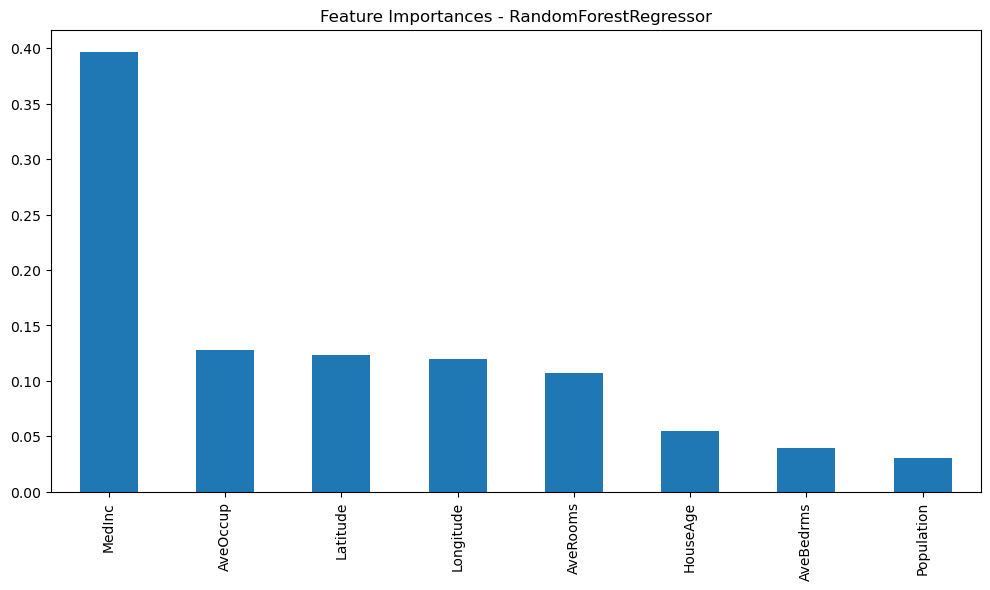

In [35]:
# Оценка важности признаков для RandomForestRegressor
importances_rf = best_model_rf.feature_importances_
features_rf = pd.Series(importances_rf, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
features_rf.plot(kind='bar')
plt.title('Feature Importances - RandomForestRegressor')
plt.show()


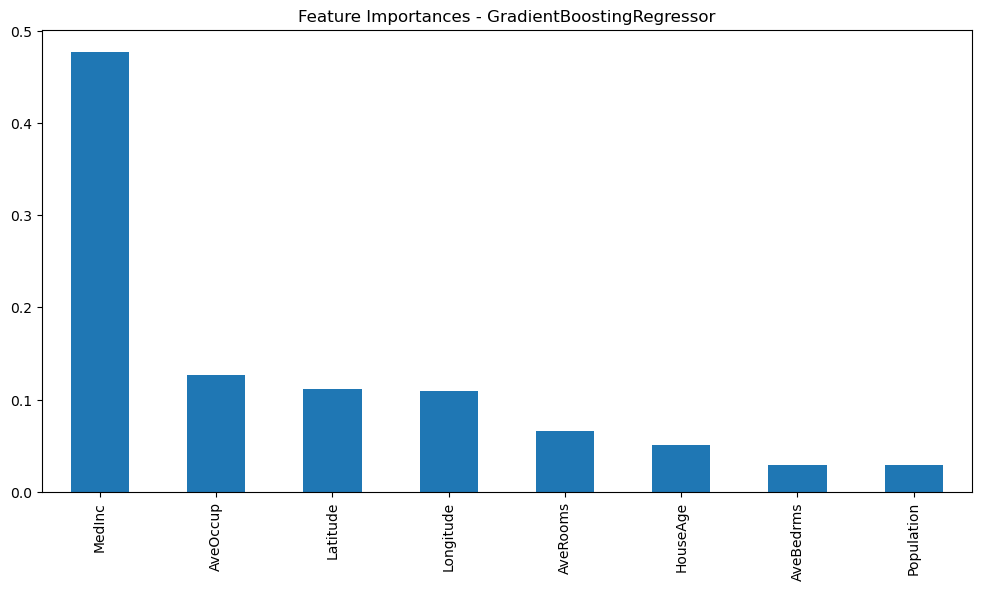

In [36]:
# Оценка важности признаков для GradientBoostingRegressor
importances_gbr = best_model_gbr.feature_importances_
features_gbr = pd.Series(importances_gbr, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
features_gbr.plot(kind='bar')
plt.title('Feature Importances - GradientBoostingRegressor')
plt.show()


## Исследование влияние удаления некоторых признаков на производительность моделей


In [40]:
# Подготовка даннных

# Удаление наиболее важных признаков
X_train_less_important = X_train.drop(columns=features_rf.head(3).index)
X_test_less_important = X_test.drop(columns=features_rf.head(3).index)

# Удаление наименее важных признаков
X_train_more_important = X_train.drop(columns=features_rf.tail(3).index)
X_test_more_important = X_test.drop(columns=features_rf.tail(3).index)

print(f"Размер X_train_less_important: {len(X_train_less_important)}")
print(f"Размер X_test_less_important: {len(X_test_less_important)}")
print(f"Размер X_train_more_important: {len(X_train_more_important)}")
print(f"Размер X_test_more_important: {len(X_test_more_important)}")
print(f"Размер y_train: {len(y_train)}")
print(f"Размер y_test: {len(y_test)}")

Размер X_train_less_important: 16512
Размер X_test_less_important: 4128
Размер X_train_more_important: 16512
Размер X_test_more_important: 4128
Размер y_train: 16512
Размер y_test: 4128


In [41]:
# Переобучение моделей на данных с удаленными важными признаками

best_model_rf_less_important = RandomForestRegressor(
    **best_params_rf,
    random_state=42,
    n_jobs=-1
)
best_model_rf_less_important.fit(X_train_less_important, y_train)

best_model_gbr_less_important = GradientBoostingRegressor(
    **best_params_gbr,
    random_state=42
)
best_model_gbr_less_important.fit(X_train_less_important, y_train)


GradientBoostingRegressor(learning_rate=0.026844247528777843, max_depth=26,
                          max_features=0.6410035105688879, min_samples_leaf=3,
                          n_estimators=293, random_state=42)

In [42]:
# Переобучение моделей на данных с удаленными неважными признаками

best_model_rf_more_important = RandomForestRegressor(
    **best_params_rf,
    random_state=42,
    n_jobs=-1
)
best_model_rf_more_important.fit(X_train_more_important, y_train)

best_model_gbr_more_important = GradientBoostingRegressor(
    **best_params_gbr,
    random_state=42
)
best_model_gbr_more_important.fit(X_train_more_important, y_train)


GradientBoostingRegressor(learning_rate=0.026844247528777843, max_depth=26,
                          max_features=0.6410035105688879, min_samples_leaf=3,
                          n_estimators=293, random_state=42)

In [43]:
# Оценка моделей на тестовой выборке после удаления важных признаков
test_preds_rf_less_important = best_model_rf_less_important.predict(X_test_less_important)
test_rmse_rf_less_important = mean_squared_error(y_test, test_preds_rf_less_important, squared=False)
test_r2_rf_less_important = r2_score(y_test, test_preds_rf_less_important)

test_preds_gbr_less_important = best_model_gbr_less_important.predict(X_test_less_important)
test_rmse_gbr_less_important = mean_squared_error(y_test, test_preds_gbr_less_important, squared=False)
test_r2_gbr_less_important = r2_score(y_test, test_preds_gbr_less_important)

print("Удаление наиболее важных признаков:")
print(f"RandomForestRegressor - RMSE: {test_rmse_rf_less_important:.2f}, R²: {test_r2_rf_less_important:.2f}")
print(f"GradientBoostingRegressor - RMSE: {test_rmse_gbr_less_important:.2f}, R²: {test_r2_gbr_less_important:.2f}")


# Оценка моделей на тестовой выборке после удаления неважных признаков
test_preds_rf_more_important = best_model_rf_more_important.predict(X_test_more_important)
test_rmse_rf_more_important = mean_squared_error(y_test, test_preds_rf_more_important, squared=False)
test_r2_rf_more_important = r2_score(y_test, test_preds_rf_more_important)

test_preds_gbr_more_important = best_model_gbr_more_important.predict(X_test_more_important)
test_rmse_gbr_more_important = mean_squared_error(y_test, test_preds_gbr_more_important, squared=False)
test_r2_gbr_more_important = r2_score(y_test, test_preds_gbr_more_important)

print("\nУдаление наименее важных признаков:")
print(f"RandomForestRegressor - RMSE: {test_rmse_rf_more_important:.2f}, R²: {test_r2_rf_more_important:.2f}")
print(f"GradientBoostingRegressor - RMSE: {test_rmse_gbr_more_important:.2f}, R²: {test_r2_gbr_more_important:.2f}")


Удаление наиболее важных признаков:
RandomForestRegressor - RMSE: 0.79, R²: 0.52
GradientBoostingRegressor - RMSE: 0.78, R²: 0.53

Удаление наименее важных признаков:
RandomForestRegressor - RMSE: 0.50, R²: 0.81
GradientBoostingRegressor - RMSE: 0.48, R²: 0.82
